In [184]:
from os import listdir
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import seaborn
from skimage import io
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, classification_report
import imblearn
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization
from keras.optimizers import Adam

In [3]:
#Ispisujemo ukupan broj fajlova pacijenata i izvlacimo identifikacione brojeve u listu
patient_file_ids = listdir("./dataset")
print(len(patient_file_ids))

279


In [4]:
#proveravamo sadrzaj fajla za jednog pacijenta
patient_file = listdir("./dataset/8863")
print(len(patient_file))
print(patient_file)

2
['0', '1']


In [5]:
#proveravamo raspodelu slika kancera i onih koje nisu kancer
class_0_total=0
class_1_total=0

for patient_file_id in patient_file_ids:
    class_0 = listdir('./dataset/' + patient_file_id + '/0')
    class_1 = listdir('./dataset/' + patient_file_id + '/1')
    class_0_total += len(class_0)
    class_1_total += len(class_1) 

total = class_0_total + class_1_total
    
print('Number of patches in Class 0: {0}'.format(class_0_total))
print('Number of patches in Class 1: {0}'.format(class_1_total))
print('Total number of patches: {0}'.format(total))

Number of patches in Class 0: 198738
Number of patches in Class 1: 78786
Total number of patches: 277524


In [6]:
#kreiramo dataframe sa svim potrebnim informacijama uz filtriranje slika koje nisu odgovarajuce velicine
#skup podataka je takav da nam neki od delova vec fale, zbog cega ovde izbacujemo slike koje ne zadovoljavaju dimenzije
columns = ['patient_file_id','x','y','is_cancer','img']
rows = []

for patient_file_id in patient_file_ids:
    for c in [0,1]:
        path_to_class = './dataset/' + patient_file_id + '/' + str(c) + '/'
        imgs = listdir(path_to_class)
        paths_to_imgs = [path_to_class + img for img in imgs]
        img_coords = [img.split('_',4)[2:4] for img in imgs]
        x_coords = [int(coords[0][1:]) for coords in img_coords]
        y_coords = [int(coords[1][1:]) for coords in img_coords]

        for (path,x,y) in zip(paths_to_imgs,x_coords,y_coords):
            img = io.imread(path)
            height, width, _ = img.shape
            if height == 50 and width == 50:
                values = [patient_file_id,x,y,c,img]
                rows.append({k:v for (k,v) in zip(columns,values)})

In [7]:
#ucitavamo listu u dataframe
data = pd.DataFrame(rows)
print(data.shape)
data.head()

(275222, 5)


,patient_file_id,x,y,is_cancer,img
0,10253,1001,1001,0,"[[[226, 164, 206], [224, 154, 196], [225, 175,..."
1,10253,1001,1051,0,"[[[219, 150, 197], [217, 158, 201], [228, 173,..."
2,10253,1001,1101,0,"[[[248, 245, 249], [248, 246, 248], [249, 246,..."
3,10253,1001,1151,0,"[[[249, 247, 249], [249, 247, 249], [249, 247,..."
4,10253,1001,1201,0,"[[[241, 231, 237], [246, 242, 245], [234, 222,..."


In [8]:
#proveravamo raspodelu podataka i nakon filtriranja
class_0_total = len(data[data.is_cancer == 0].index)
class_1_total = len(data[data.is_cancer == 1].index)
total = len(data.index)
    
print('Number of patches in Class 0 after filtering: {0}'.format(class_0_total))
print('Number of patches in Class 1 after filtering: {0}'.format(class_1_total))
print('Total number of patches after filtering: {0}'.format(total))
print('Percentage of negative images: {0:.2f}'.format(class_0_total/total*100))
print('Percentage of positive images: {0:.2f}'.format(class_1_total/total*100))

Number of patches in Class 0 after filtering: 196454
Number of patches in Class 1 after filtering: 78768
Total number of patches after filtering: 275222
Percentage of negative images: 71.38
Percentage of positive images: 28.62


In [9]:
#izvlacimo procenat delova slike na kojima je detektovan kancer za svakog od pacijenata
#vidimo da se vrednosti mogu dosta razlikovati od pacijenta do pacijenta
cancer_percentage = (data.groupby('patient_file_id').is_cancer.value_counts()/data.groupby('patient_file_id').is_cancer.size()).unstack()
cancer_percentage.head()

is_cancer,0,1
patient_file_id,,
10253,0.872495,0.127505
10254,0.910377,0.089623
10255,0.665441,0.334559
10256,0.750000,0.250000
10257,0.672441,0.327559


C:\Users\nadrasko\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\nadrasko\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


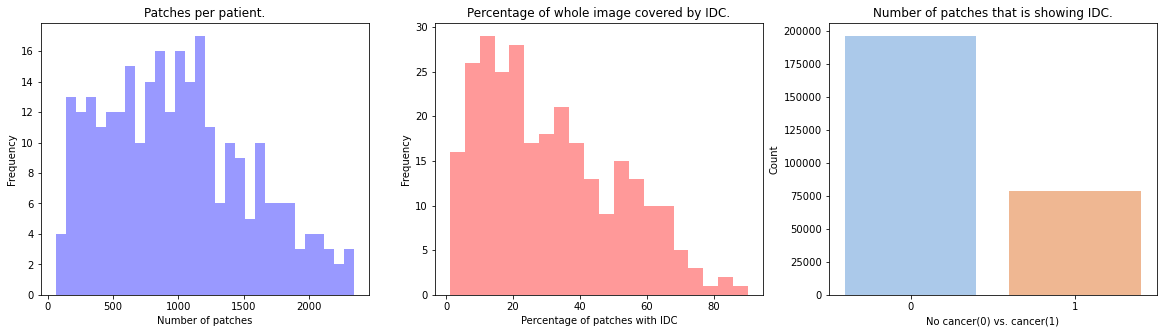

In [10]:
#iscrtavamo neke osnovne podatke na grafiku
fig, ax = plt.subplots(1,3,figsize=(20,5))

seaborn.distplot(data.groupby("patient_file_id").size(), ax=ax[0], color='blue', kde=False, bins=30)
ax[0].set_xlabel('Number of patches')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Patches per patient.')

seaborn.distplot(cancer_percentage.loc[:, 1]*100, ax=ax[1], color='red', kde=False, bins=20)
ax[1].set_title('Percentage of whole image covered by IDC.')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Percentage of patches with IDC')

seaborn.countplot(data.is_cancer, palette='pastel', ax=ax[2])
ax[2].set_ylabel('Count')
ax[2].set_xlabel('No cancer(0) vs. cancer(1)')
ax[2].set_title('Number of patches that is showing IDC.');

plt.show()

In [11]:
#izvlacimo par slika kako bismo imali bolji uvid u skup podataka
no_cancer_imgs = data[data.is_cancer==0].sample(n=25, replace=False).img.values
cancer_imgs = data[data.is_cancer==1].sample(n=25, replace=False).img.values

In [12]:
#pomocna funkcija za iscrtavanje slika
def show_imgs(imgs, n):
    fig,ax = plt.subplots(n,n,figsize = (25,25))
    for row in range(n):
        for column in range(n):
            ax[row,column].imshow(imgs[column + n*row])
            ax[row,column].grid(False)
    plt.show()

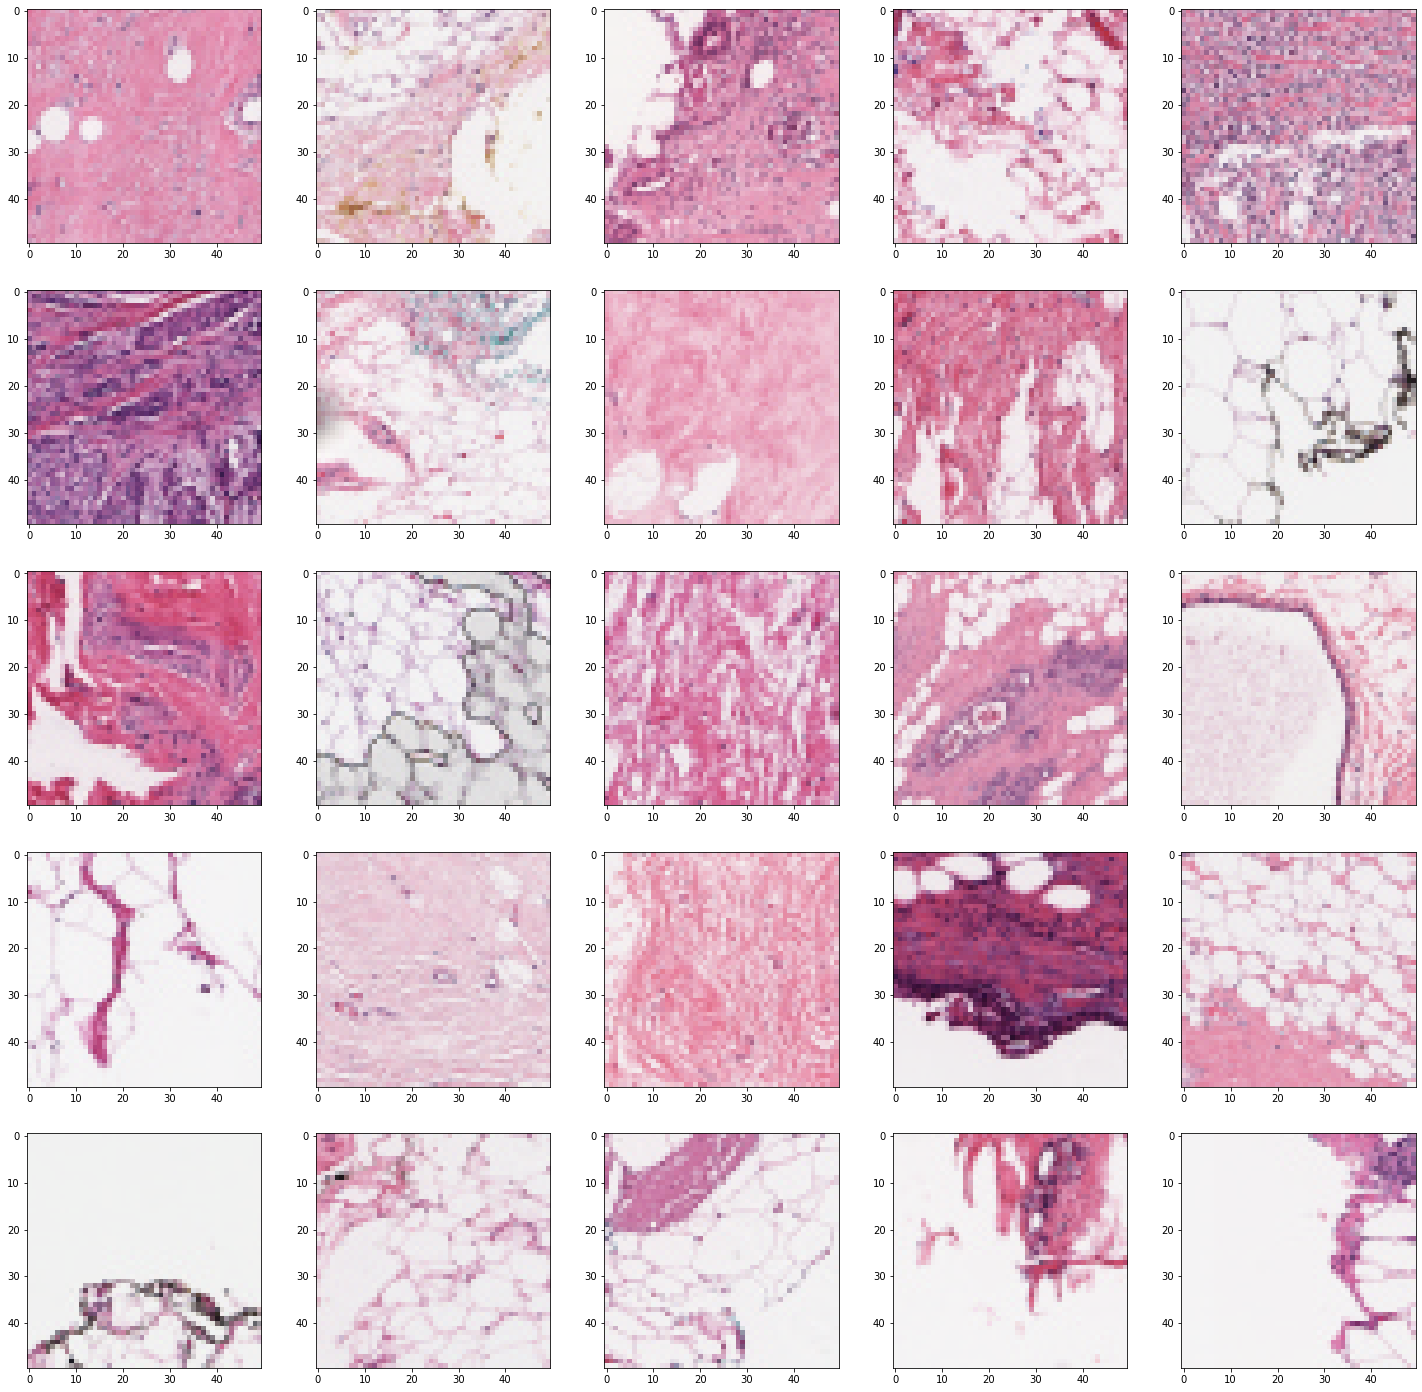

In [13]:
show_imgs(no_cancer_imgs,5)

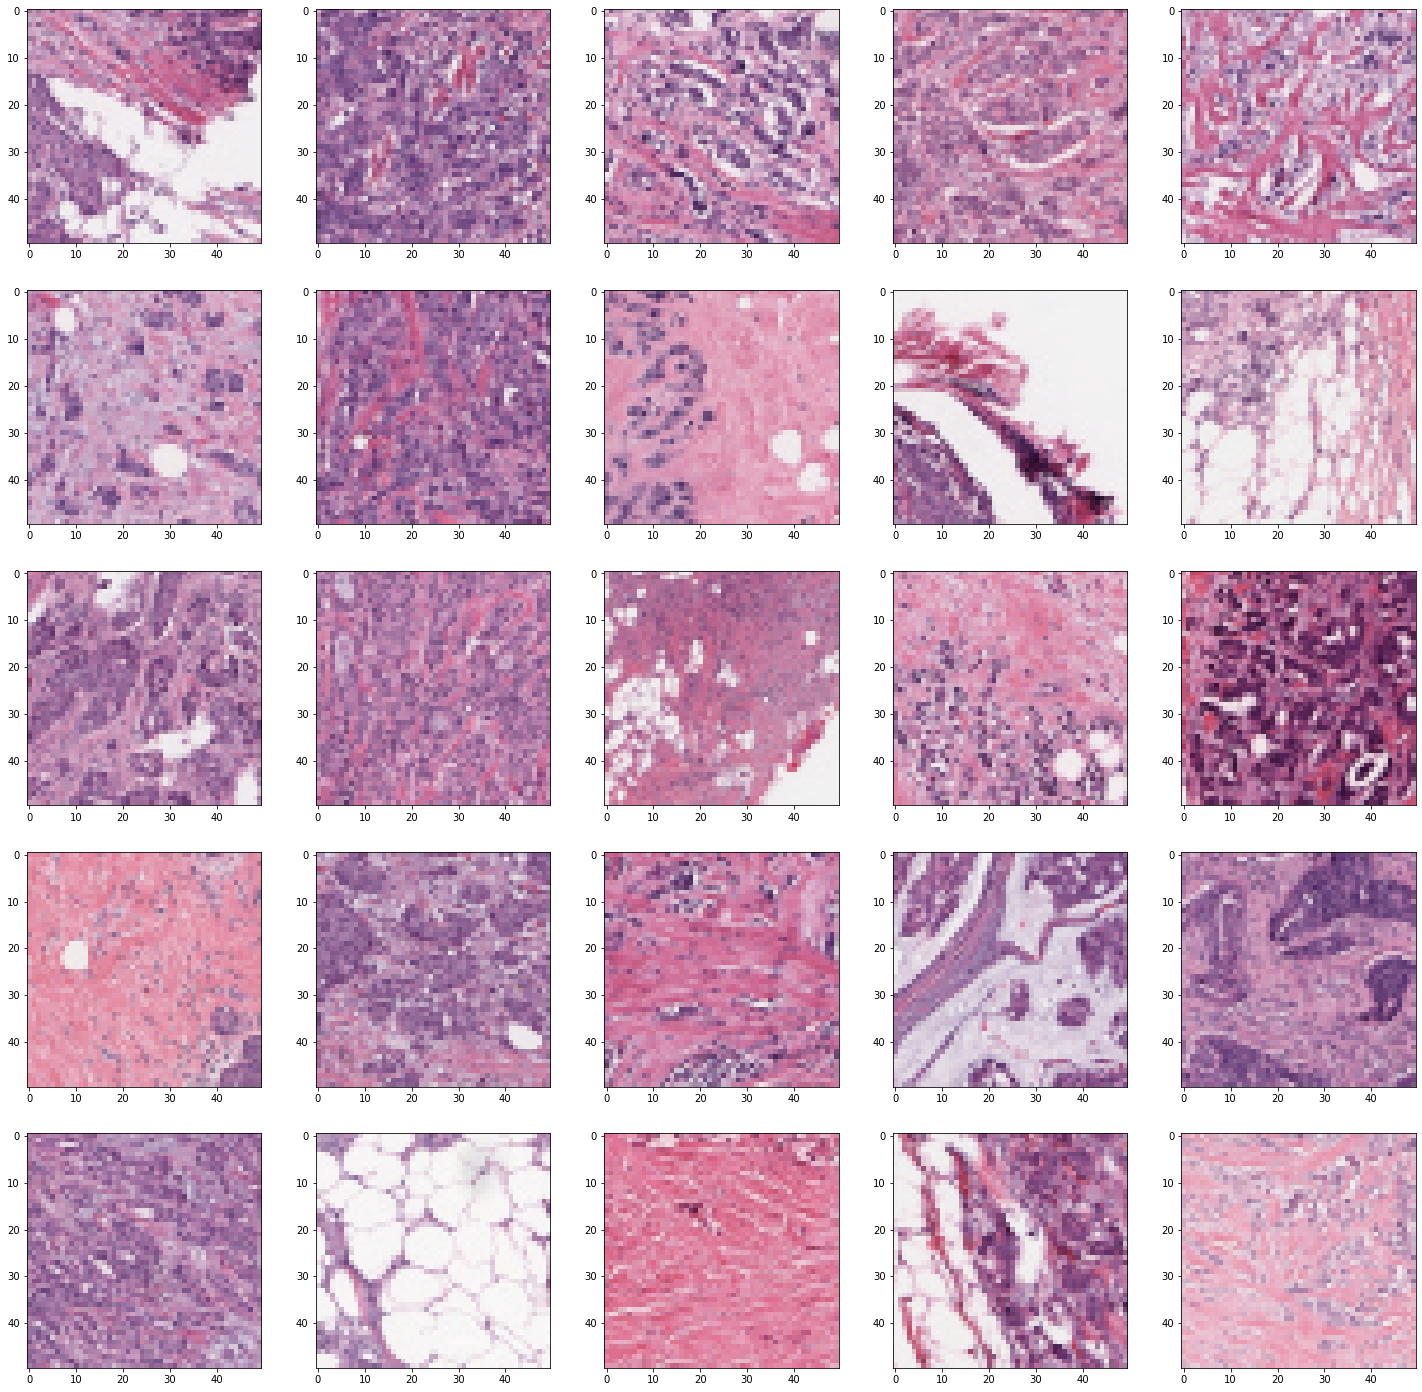

In [14]:
show_imgs(cancer_imgs,5)

In [15]:
#iscrtavamo one delove slike koji su klasifikovani kao kancer crveno, a one koji nisu roze, vidimo da delovi slike ne cine citavu sliku vec imamo nedostajucih padataka
colors = ['pink', 'red']

def visualise_tissue(data, n):
    patient_file_ids = np.random.choice(data.patient_file_id.unique(), size=n*n, replace=False)
    fig, ax = plt.subplots(n,n,figsize=(25, 25))
    for row in range(n):
        for column in range(n):
            patient_file_id = patient_file_ids[column + n*row]
            patient_df = data.loc[data['patient_file_id'] == patient_file_id]
            ax[row,column].scatter(patient_df.x.values, patient_df.y.values, c=patient_df.is_cancer.values, cmap=matplotlib.colors.ListedColormap(colors), s=20)
            ax[row,column].set_title("patient " + patient_file_id)
    plt.show()

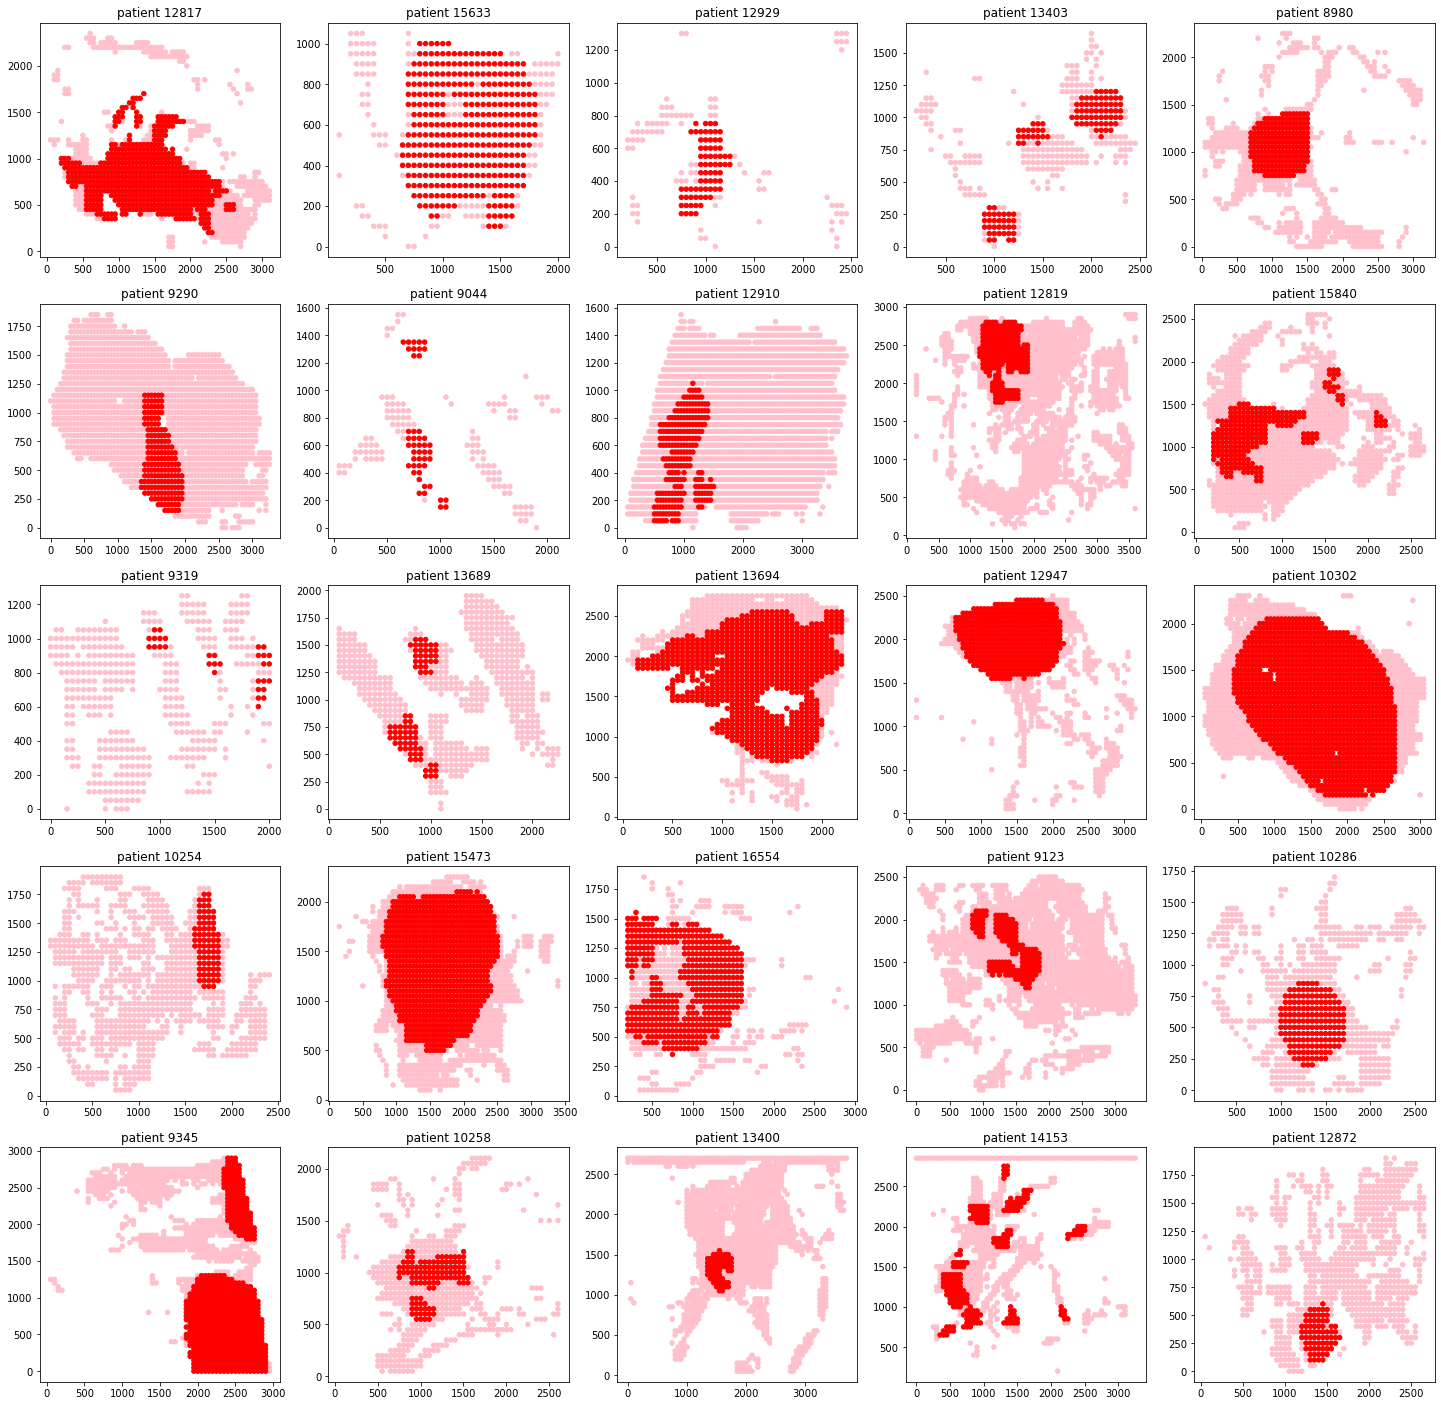

In [16]:
visualise_tissue(data,5)

In [197]:
#za jednog pacijenta iscrtavamo sliku koristeci njene delove, uz to da kancer mozemo istaci ili iscrtati originalnu sliku
def visualise_tissue_one_patient(patient_df, highlight=False):
    max_dim = np.max((*patient_df.x,*patient_df.y))
    grid = 255*np.ones(shape = (max_dim + 50, max_dim + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_dim + 50, max_dim + 50, 3)).astype(np.uint8)
    for x,y,c,img in zip(patient_df['x'],patient_df['y'],patient_df['is_cancer'],patient_df['img']):
        grid[y:y+50,x:x+50] = img
        if c != 0:
            mask[y:y+50,x:x+50] = [0,0,255]
    if highlight == False:
        img = grid
    else:
        alpha = 0.77
        img = (mask * (1.0 - alpha) + grid * alpha).astype('uint8')
    return img

In [18]:
def visualise_tissue_list(data, n):
    patient_file_ids = np.random.choice(data.patient_file_id.unique(), size=n*n, replace=False)
    fig, ax = plt.subplots(n,n,figsize=(30, 30))
    for row in range(n):
        for column in range(n):            
            patient_file_id = patient_file_ids[column + n*row]
            patient_df = data.loc[data['patient_file_id'] == patient_file_id]
            image = visualise_tissue_one_patient(patient_df, highlight=True)
            ax[row,column].set_title("Breast tissue of patient: " + patient_file_id)        
            ax[row,column].imshow(image)            
    plt.show()

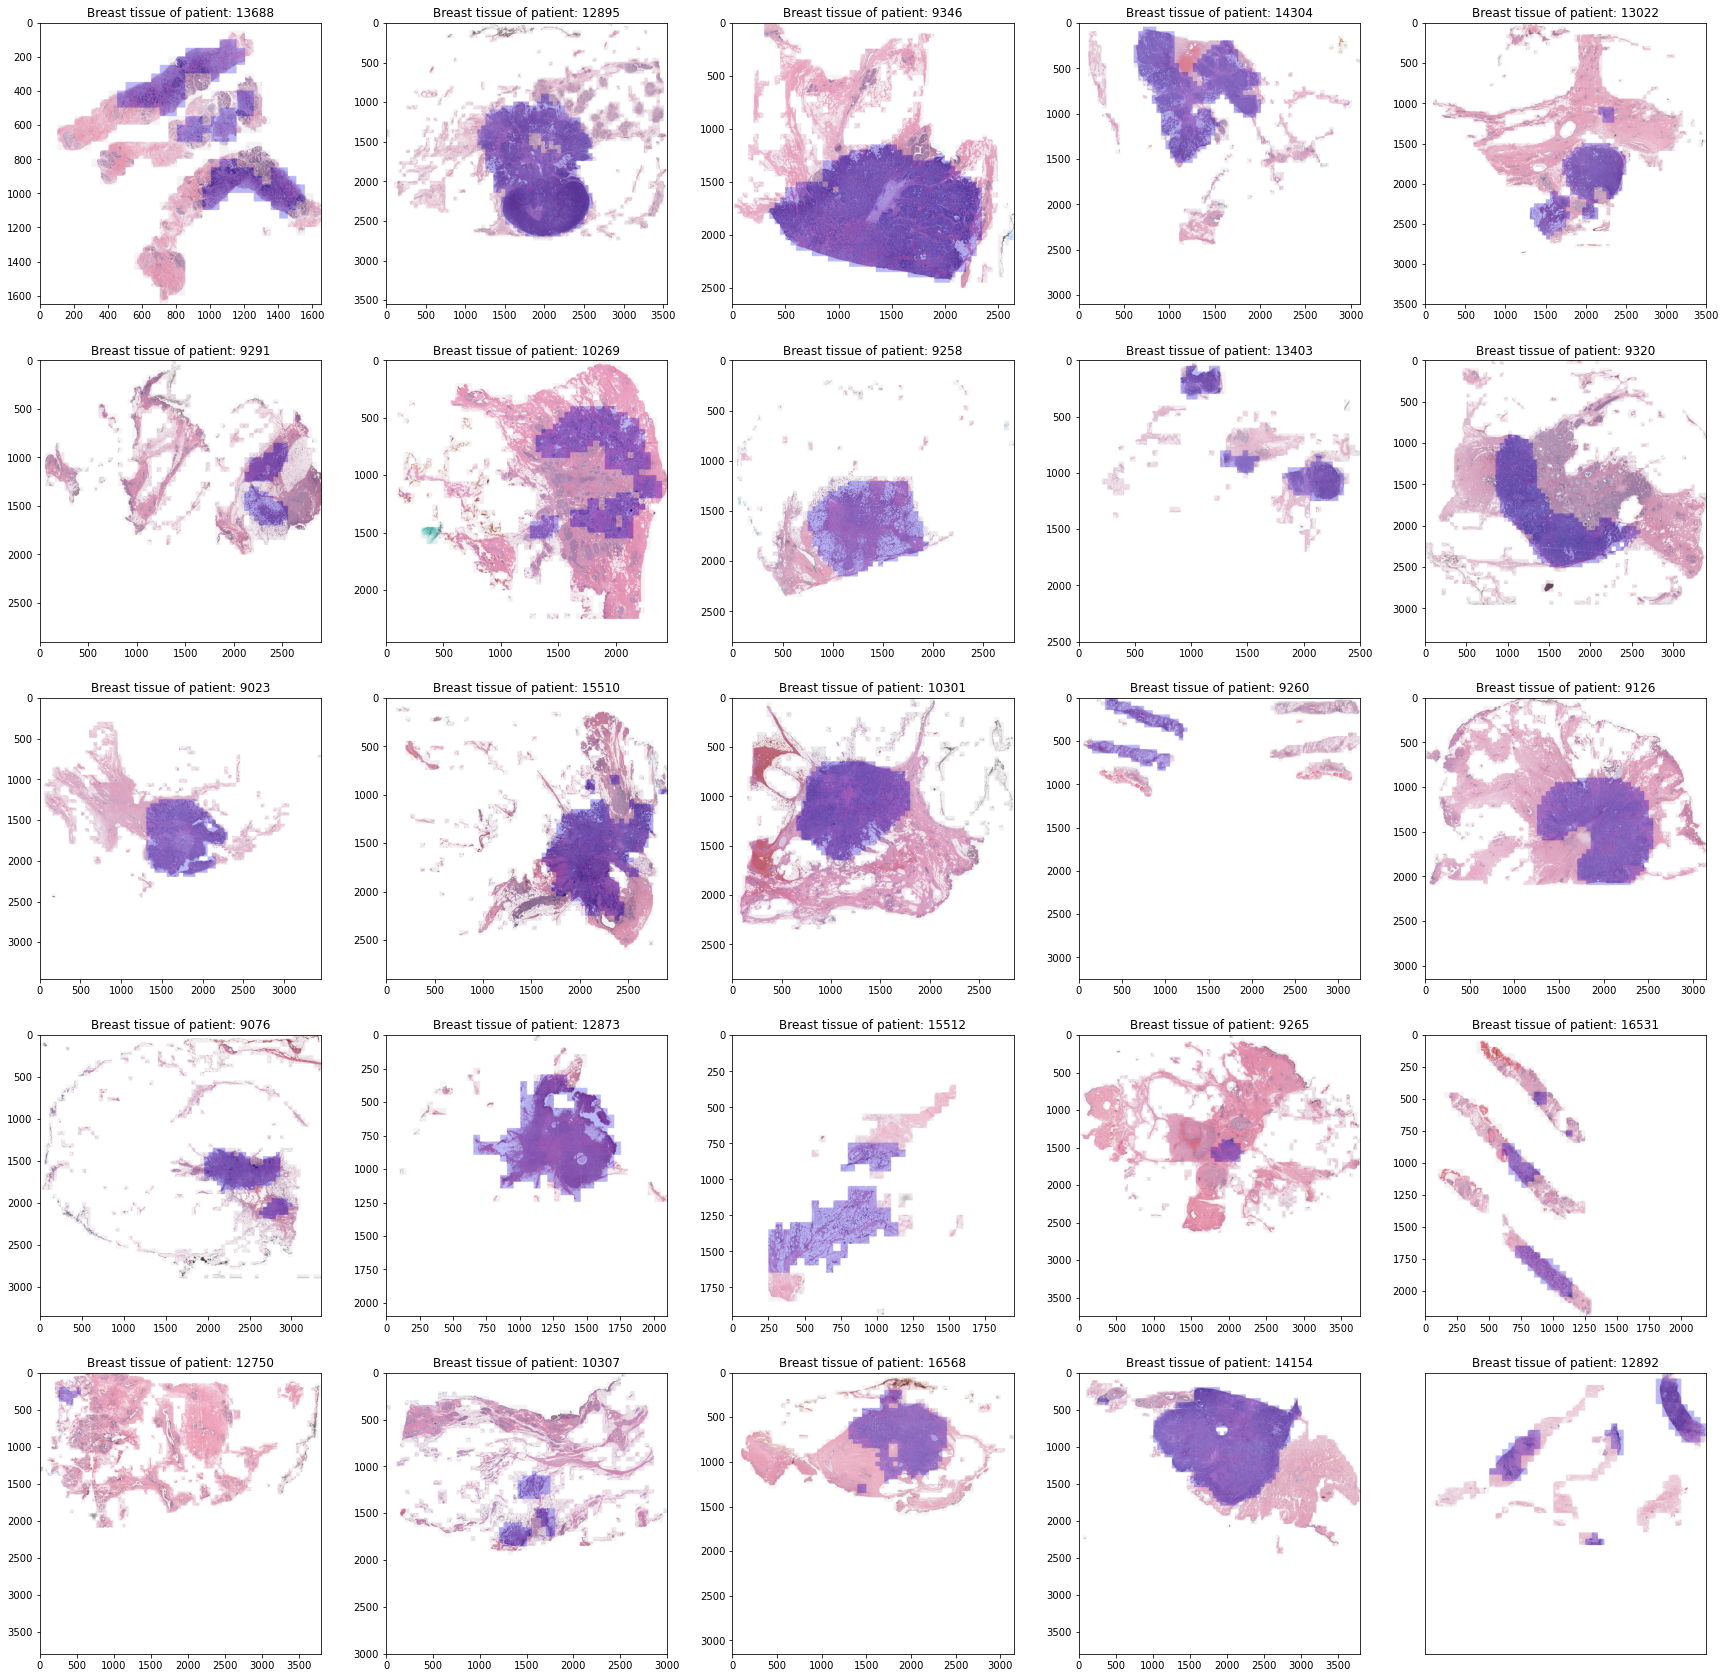

In [19]:
visualise_tissue_list(data,5)

In [77]:
#removing one patient file so we can later show whole model on it and use the rest of pictures just for classification, not checking patient id
test_patient = data[data.patient_file_id=='9320']
data = data.drop(data[data.patient_file_id=='9320'].index)

In [90]:
#formiramo podatke za treniranje modela
X = np.stack(data.img, axis=0)
y = np.stack(data.is_cancer, axis=0)
X.shape, y.shape

((273359, 50, 50, 3), (273359,))

In [91]:
#delomo podatke na testne, validacione i one za treniranje modela
X_train_val, X_test, y_train_val, y_test = model_selection.train_test_split(X, y, test_size=0.2, stratify=y)

In [92]:
X_train_val.shape, X_test.shape, y_train_val.shape, y_test.shape

((218687, 50, 50, 3), (54672, 50, 50, 3), (218687,), (54672,))

In [93]:
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val)

In [94]:
np.bincount(y_train), np.bincount(y_val), np.bincount(y_test)

(array([124826,  50123], dtype=int64),
 array([31207, 12531], dtype=int64),
 array([39009, 15663], dtype=int64))

In [95]:
y_train = to_categorical(y_train, 2)
y_val = to_categorical(y_val, 2)
y_train_val = to_categorical(y_train_val, 2)

In [96]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((174949, 50, 50, 3), (43738, 50, 50, 3), (174949, 2), (43738, 2))

In [97]:
X_train = X_train.reshape((X_train.shape[0],50*50*3))
X_val = X_val.reshape((X_val.shape[0],50*50*3))
X_train.shape, X_val.shape

((174949, 7500), (43738, 7500))

In [99]:
#trying smote for imbalanced dataset
smote = imblearn.over_sampling.SMOTE(random_state=0, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_val_smote, y_val_smote = smote.fit_resample(X_val, y_val)
X_train_val_smote = np.concatenate((X_train_smote,X_val_smote),axis=0)
y_train_val_smote = np.concatenate((y_train_smote,y_val_smote),axis=0)
X_train_smote.shape, y_train_smote.shape, X_val_smote.shape, y_val_smote.shape, X_train_val_smote.shape, y_train_val_smote.shape

C:\Users\nadrasko\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\nadrasko\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


((249652, 7500),
 (249652, 1),
 (62414, 7500),
 (62414, 1),
 (312066, 7500),
 (312066, 1))

In [179]:
X_train_smote = X_train_smote.reshape((X_train_smote.shape[0],50,50,3))
X_val_smote = X_val_smote.reshape((X_val_smote.shape[0],50,50,3))
X_train_val_smote = X_train_val_smote.reshape((X_train_val_smote.shape[0],50,50,3))
y_train_smote = to_categorical(y_train_smote, 2)
y_val_smote = to_categorical(y_val_smote, 2)
y_train_val_smote = to_categorical(y_train_val_smote, 2)
X_train_smote.shape, X_val_smote.shape, X_train_val_smote.shape

((249652, 50, 50, 3), (62414, 50, 50, 3), (312066, 50, 50, 3))

In [104]:
X_train = X_train.reshape((X_train.shape[0],50,50,3))
X_val = X_val.reshape((X_val.shape[0],50,50,3))
X_train.shape, X_val.shape

((174949, 50, 50, 3), (43738, 50, 50, 3))

In [115]:
def create_model1():
    model = Sequential([
        Conv2D(32, (3, 3), padding = 'same', activation = 'relu', input_shape = (50, 50, 3)),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        Conv2D(64, (3, 3), padding = 'same', activation = 'relu', input_shape = (50, 50, 3)),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        Conv2D(128, (3, 3), padding = 'same', activation = 'relu', input_shape = (50, 50, 3)),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        Conv2D(128, (3, 3), padding = 'same', activation = 'relu', input_shape = (50, 50, 3)),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation = 'relu'),
        Dropout(0.5),
        Dense(2, activation = 'sigmoid')
    ])
    model.compile(
        optimizer=Adam(lr=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy','Recall','Precision']
    )
    return model    

In [116]:
def create_model2():
    model = Sequential([
        Conv2D(filters=100, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(50,50,3)),
        BatchNormalization(),
        MaxPool2D(pool_size=(2,2), strides=(2,2)),
        Conv2D(filters=256, kernel_size=(2,2), strides=(2,2), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPool2D(pool_size=(3,3), strides=(2,2)),
        Conv2D(filters=384, kernel_size=(2,2), strides=(1,1), activation='relu', padding="same"),
        BatchNormalization(),
        Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        BatchNormalization(),
        Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPool2D(pool_size=(3,3), strides=(2,2)),
        Flatten(),
        Dense(9216,input_shape=(12544,), activation='relu'),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='sigmoid')
    ])
    model.compile(
        optimizer=Adam(lr=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy','Recall','Precision']
    )
    return model

In [156]:
#graphically show values of some relevant metrics
def show_metrics(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    prec = history.history['precision']
    val_prec = history.history['val_precision']
    recall = history.history['recall']
    val_recall = history.history['val_recall']
    fig, ax = plt.subplots(2,2,figsize=(30, 30))
    ax[0,0].plot(acc, label='Training Accuracy')
    ax[0,0].plot(val_acc, label='Validation Accuracy')
    ax[0,0].legend(loc='lower right')
    ax[0,0].set_title('Training and Validation Accuracy')
    ax[0,1].plot(loss, label='Training Loss')
    ax[0,1].plot(val_loss, label='Validation Loss')
    ax[0,1].legend(loc='lower right')
    ax[0,1].set_title('Training and Validation Loss')
    ax[1,0].plot(prec, label='Training Precision')
    ax[1,0].plot(val_prec, label='Validation Precision')
    ax[1,0].legend(loc='lower right')
    ax[1,0].set_title('Training and Validation Precision')
    ax[1,1].plot(recall, label='Training Recall')
    ax[1,1].plot(val_recall, label='Validation Recall')
    ax[1,1].legend(loc='lower right')
    ax[1,1].set_title('Training and Validation Recall')
    plt.show()

In [150]:
#first iteration of training model, using validation data and bigger batches
model1 = create_model1()
history_model1 = model1.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 15, batch_size = 100)

Epoch 1/15
1750/1750 [==============================] - 263s 150ms/step - loss: 0.8546 - accuracy: 0.7134 - recall: 0.7114 - precision: 0.7028 - val_loss: 0.6809 - val_accuracy: 0.5397 - val_recall: 0.5384 - val_precision: 0.5403
Epoch 2/15
1750/1750 [==============================] - 260s 149ms/step - loss: 0.4471 - accuracy: 0.8099 - recall: 0.8082 - precision: 0.8103 - val_loss: 0.6135 - val_accuracy: 0.6781 - val_recall: 0.6728 - val_precision: 0.6796
Epoch 3/15
1750/1750 [==============================] - 261s 149ms/step - loss: 0.4119 - accuracy: 0.8264 - recall: 0.8253 - precision: 0.8268 - val_loss: 0.4135 - val_accuracy: 0.8307 - val_recall: 0.8302 - val_precision: 0.8310
Epoch 4/15
1750/1750 [==============================] - 264s 151ms/step - loss: 0.3919 - accuracy: 0.8335 - recall: 0.8337 - precision: 0.8335 - val_loss: 0.4347 - val_accuracy: 0.8320 - val_recall: 0.8334 - val_precision: 0.8311
Epoch 5/15
1750/1750 [==============================] - 261s 149ms/step - loss: 

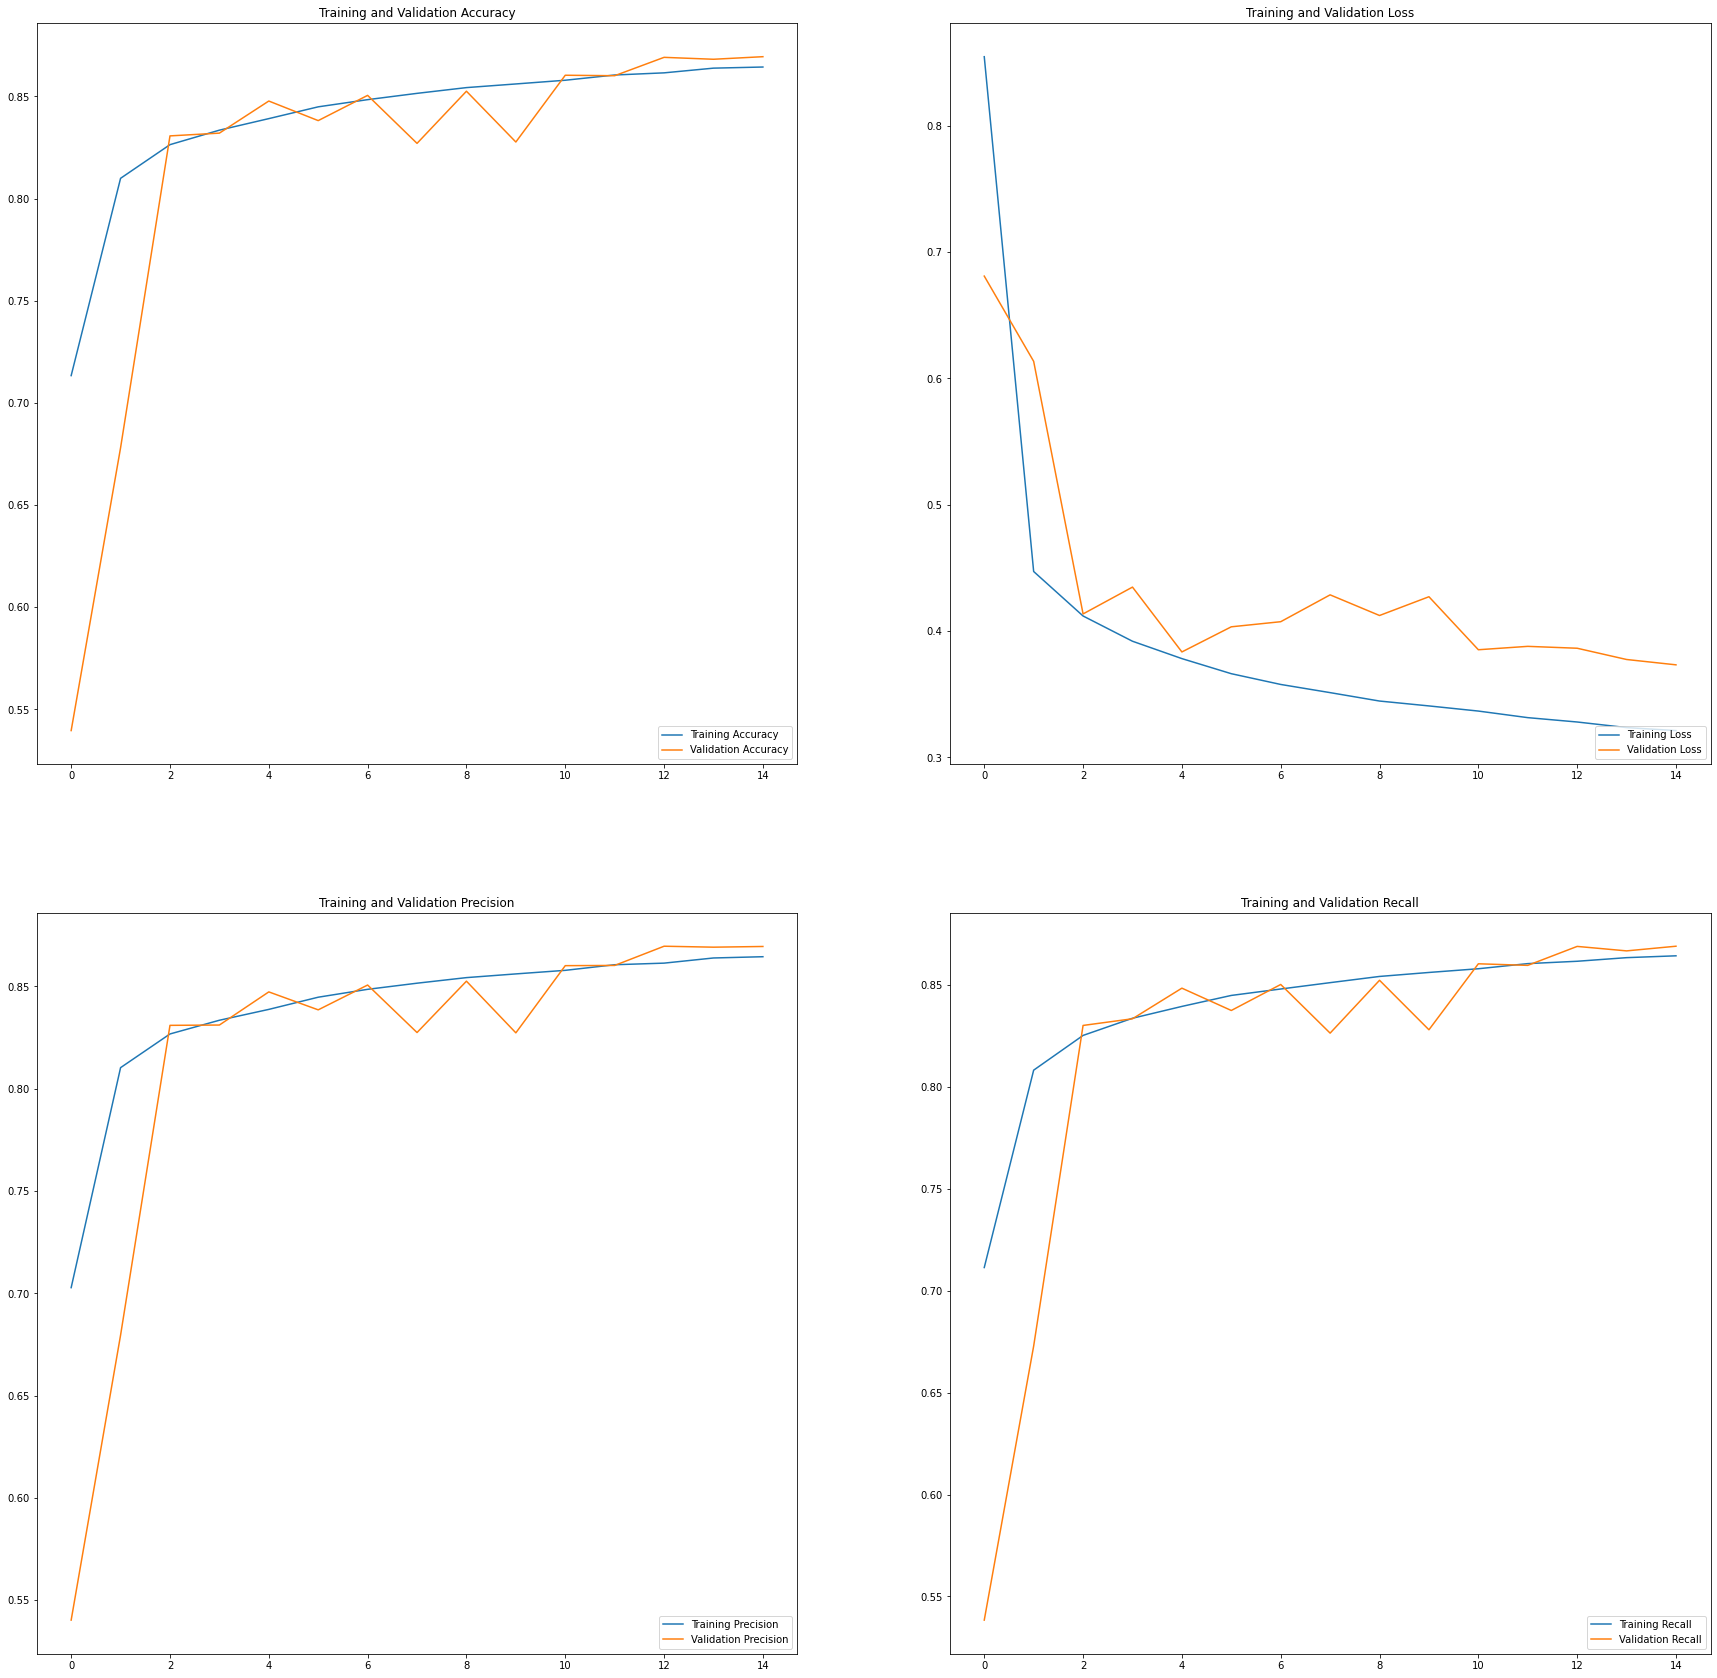

In [157]:
show_metrics(history_model1)

In [158]:
y_predicted_model1 = model1.predict(X_test)
y_predicted_model1 = np.argmax(y_predicted_model1,axis=1)
y_predicted_model1

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [160]:
matrix = confusion_matrix(y_test, y_predicted_model1)
print(matrix)

[[35440  3569]
 [ 3643 12020]]


In [161]:
report = classification_report(y_test, y_predicted_model1)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.91      0.91     39009
           1       0.77      0.77      0.77     15663

    accuracy                           0.87     54672
   macro avg       0.84      0.84      0.84     54672
weighted avg       0.87      0.87      0.87     54672



In [165]:
#retraining model with smaller batches with data that include validation set
history_model1 = model1.fit(X_train_val, y_train_val, epochs = 10, batch_size = 50)

Epoch 1/10
4374/4374 [==============================] - 402s 92ms/step - loss: 0.3234 - accuracy: 0.8634 - recall: 0.8633 - precision: 0.8634
Epoch 2/10
4374/4374 [==============================] - 400s 91ms/step - loss: 0.3172 - accuracy: 0.8667 - recall: 0.8667 - precision: 0.8666
Epoch 3/10
4374/4374 [==============================] - 400s 92ms/step - loss: 0.3144 - accuracy: 0.8683 - recall: 0.8682 - precision: 0.8683
Epoch 4/10
4374/4374 [==============================] - 400s 91ms/step - loss: 0.3105 - accuracy: 0.8699 - recall: 0.8699 - precision: 0.8699
Epoch 5/10
4374/4374 [==============================] - 400s 91ms/step - loss: 0.3087 - accuracy: 0.8709 - recall: 0.8711 - precision: 0.8708
Epoch 6/10
4374/4374 [==============================] - 399s 91ms/step - loss: 0.3056 - accuracy: 0.8728 - recall: 0.8728 - precision: 0.8728
Epoch 7/10
4374/4374 [==============================] - 399s 91ms/step - loss: 0.3022 - accuracy: 0.8737 - recall: 0.8738 - precision: 0.8738
Epoch 

In [166]:
y_predicted_model1 = model1.predict(X_test)
y_predicted_model1 = np.argmax(y_predicted_model1,axis=1)
y_predicted_model1

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [167]:
matrix = confusion_matrix(y_test, y_predicted_model1)
print(matrix)

[[35669  3340]
 [ 3360 12303]]


In [168]:
report = classification_report(y_test, y_predicted_model1)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.91      0.91     39009
           1       0.79      0.79      0.79     15663

    accuracy                           0.88     54672
   macro avg       0.85      0.85      0.85     54672
weighted avg       0.88      0.88      0.88     54672



In [169]:
model_path = './model1.h5'
model1.save(model_path)

In [170]:
model1_smote = create_model1()
history_model1_smote = model1_smote.fit(X_train_smote, y_train_smote, validation_data = (X_val, y_val), epochs = 10, batch_size =100)

Epoch 1/8
2497/2497 [==============================] - 372s 149ms/step - loss: 0.7377 - accuracy: 0.7405 - recall: 0.7425 - precision: 0.7338 - val_loss: 0.8762 - val_accuracy: 0.3425 - val_recall: 0.3422 - val_precision: 0.3427
Epoch 2/8
2497/2497 [==============================] - 372s 149ms/step - loss: 0.3631 - accuracy: 0.8505 - recall: 0.8497 - precision: 0.8508 - val_loss: 0.4648 - val_accuracy: 0.8193 - val_recall: 0.8177 - val_precision: 0.8205
Epoch 3/8
2497/2497 [==============================] - 372s 149ms/step - loss: 0.3226 - accuracy: 0.8651 - recall: 0.8649 - precision: 0.8647 - val_loss: 0.4722 - val_accuracy: 0.8159 - val_recall: 0.8153 - val_precision: 0.8167
Epoch 4/8
2497/2497 [==============================] - 373s 149ms/step - loss: 0.3031 - accuracy: 0.8727 - recall: 0.8726 - precision: 0.8731 - val_loss: 0.4895 - val_accuracy: 0.7899 - val_recall: 0.7873 - val_precision: 0.7911
Epoch 5/8
2497/2497 [==============================] - 372s 149ms/step - loss: 0.288

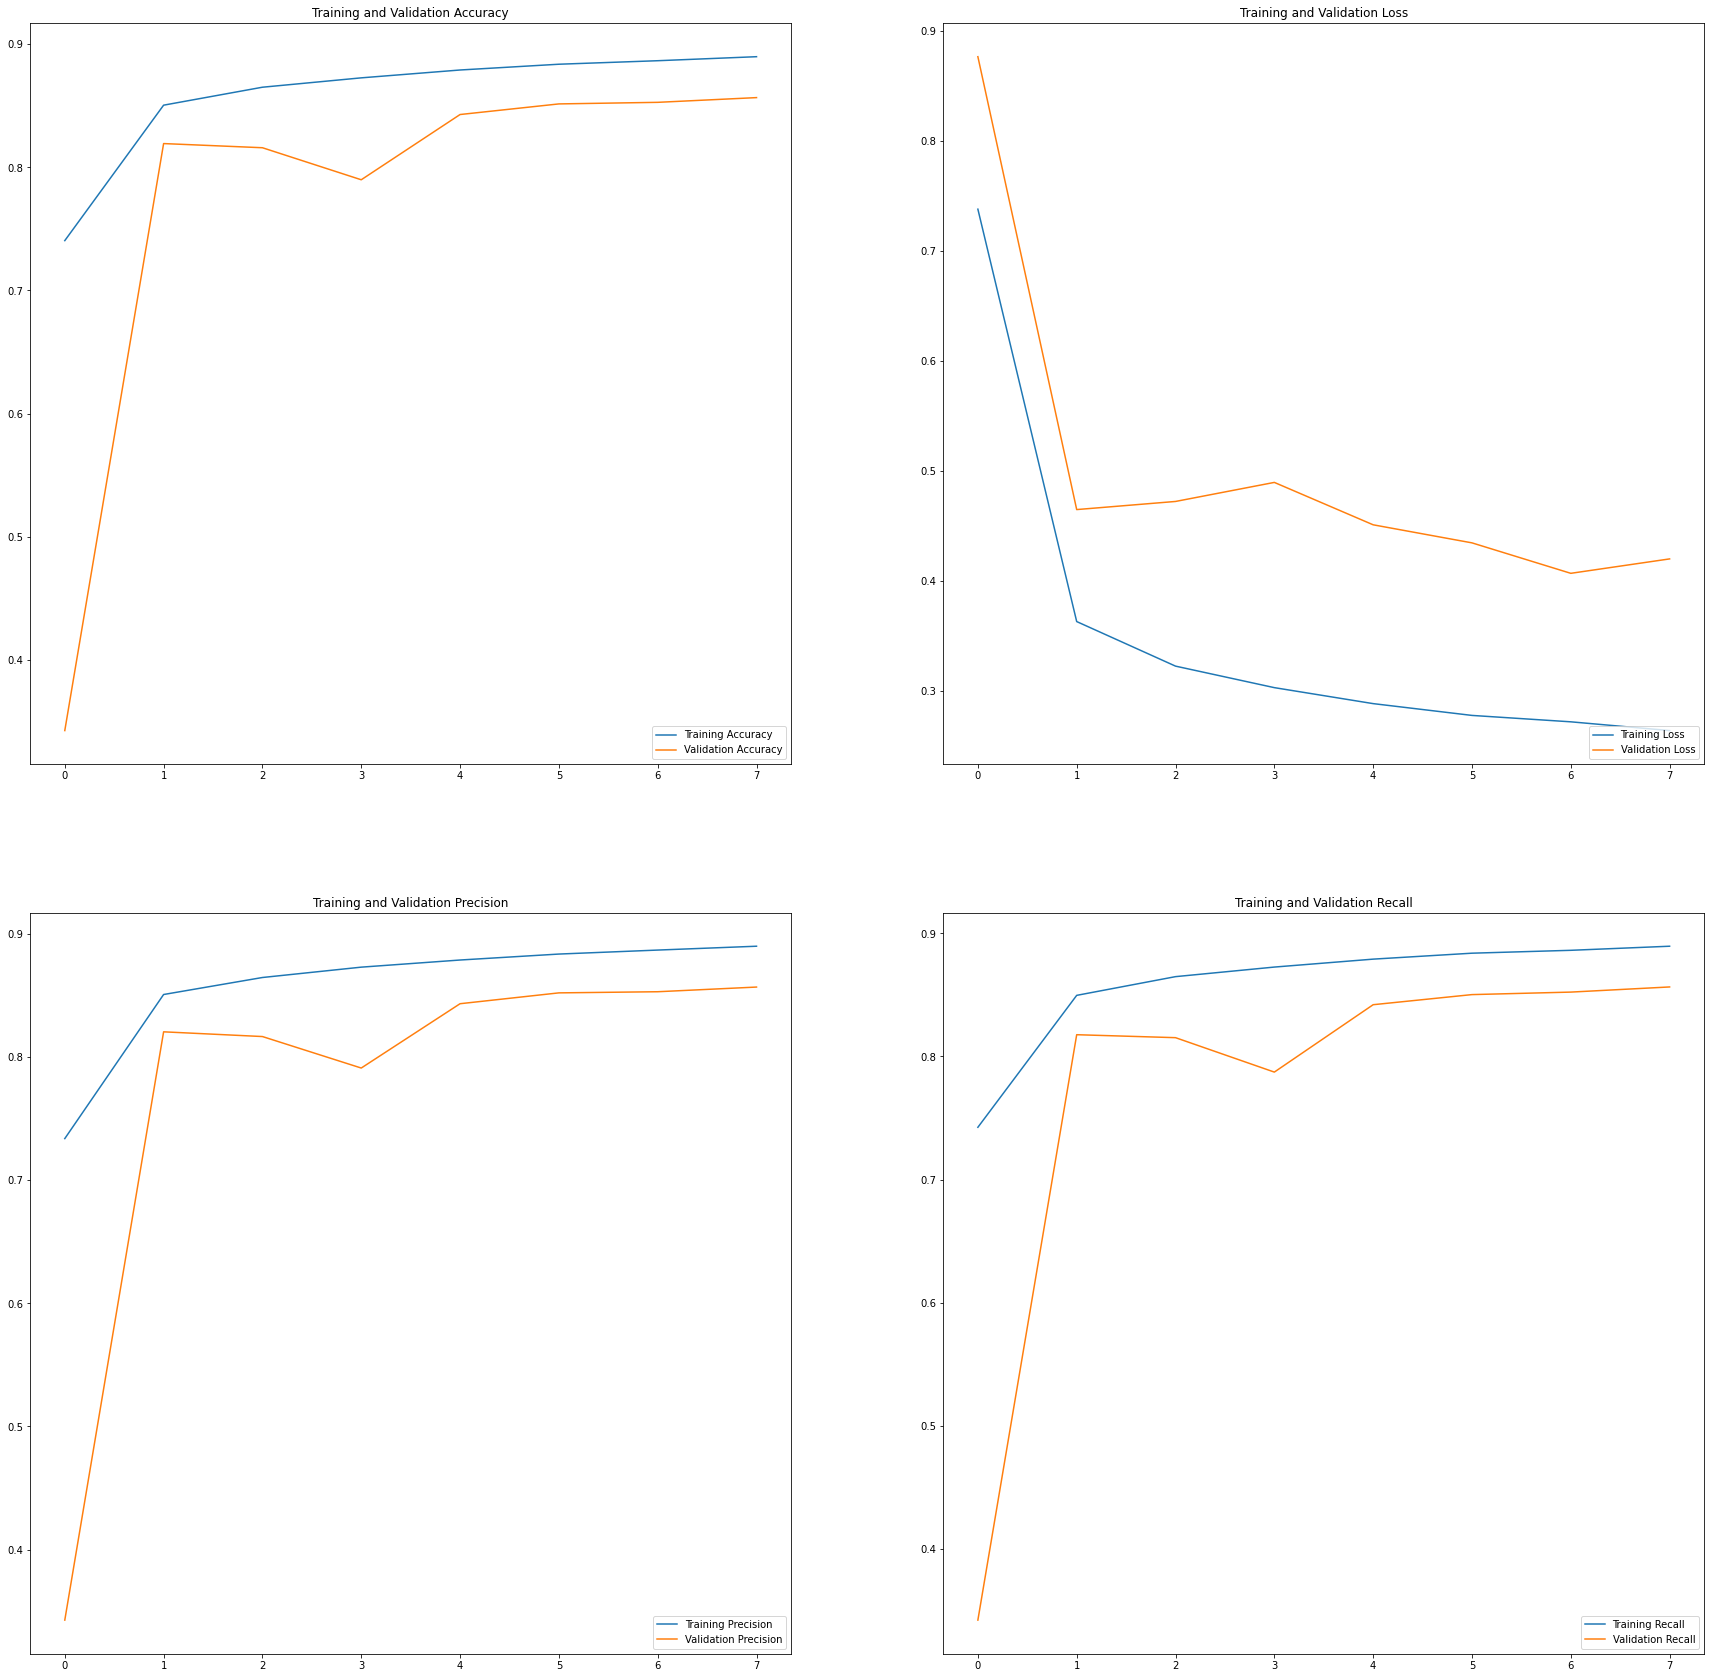

In [171]:
show_metrics(history_model1_smote)

In [175]:
y_predicted_model1_smote = model1_smote.predict(X_test)
y_predicted_model1_smote = np.argmax(y_predicted_model1_smote,axis=1)
y_predicted_model1_smote

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [176]:
matrix = confusion_matrix(y_test, y_predicted_model1_smote)
print(matrix)

[[34487  4522]
 [ 3658 12005]]


In [177]:
report = classification_report(y_test, y_predicted_model1_smote)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.88      0.89     39009
           1       0.73      0.77      0.75     15663

    accuracy                           0.85     54672
   macro avg       0.82      0.83      0.82     54672
weighted avg       0.85      0.85      0.85     54672



In [ ]:
#retraining model with smaller batches with data that include validation set
history_model1_smote = model1_smote.fit(X_train_val_smote, y_train_val_smote, epochs = 8, batch_size = 50)

Epoch 1/3
3869/6242 [=================>............] - ETA: 3:32 - loss: 0.2388 - accuracy: 0.9007 - recall: 0.9007 - precision: 0.9009

In [ ]:
y_predicted_model1_smote = model1_smote.predict(X_test)
y_predicted_model1_smote = np.argmax(y_predicted_model1_smote,axis=1)
y_predicted_model1_smote

In [ ]:
matrix = confusion_matrix(y_test, y_predicted_model1_smote)
print(matrix)

In [ ]:
report = classification_report(y_test, y_predicted_model1_smote)
print(report)

In [187]:
model_path = './model1_smote.h5'
model1_smote.save(model_path)

In [202]:
test_patient = data[data.patient_file_id=='15510']
#create predictions and visualise them for one patient that is extracted before the training
X_test_patient = np.stack(test_patient.img, axis=0)
y_test_patient = np.stack(test_patient.is_cancer, axis=0)
X_test_patient.shape, y_test_patient.shape

((1061, 50, 50, 3), (1061,))

In [203]:
img = visualise_tissue_one_patient(test_patient,highlight=True)

In [204]:
#load saved model
loaded_model1 = load_model('./model1.h5')
loaded_model1.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 50, 50, 32)        896       
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
dropout_58 (Dropout)         (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_59 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 12, 12, 128)     

In [205]:
y_predicted1 = loaded_model1.predict(X_test_patient)
y_predicted1 = np.argmax(y_predicted1,axis=1)
y_predicted1

array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

In [206]:
matrix = confusion_matrix(y_test_patient, y_predicted1)
print(matrix)

[[616  89]
 [ 85 271]]


In [207]:
test_patient['is_cancer'] = y_predicted1
img1 = visualise_tissue_one_patient(test_patient,highlight=True)

<ipython-input-207-550cccf0f4f5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_patient['is_cancer'] = y_predicted1


In [208]:
loaded_model1_smote = load_model('./model1_smote.h5')
loaded_model1_smote.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 50, 50, 32)        896       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
dropout_63 (Dropout)         (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_64 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 12, 12, 128)     

In [209]:
y_predicted1_smote = loaded_model1_smote.predict(X_test_patient)
y_predicted1_smote = np.argmax(y_predicted1_smote,axis=1)
y_predicted1_smote

array([0, 1, 0, ..., 1, 0, 1], dtype=int64)

In [210]:
matrix = confusion_matrix(y_test_patient, y_predicted1_smote)
print(matrix)

[[589 116]
 [108 248]]


In [211]:
test_patient['is_cancer'] = y_predicted1_smote
img2 = visualise_tissue_one_patient(test_patient,highlight=True)

<ipython-input-211-86b66143a9e7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_patient['is_cancer'] = y_predicted1_smote


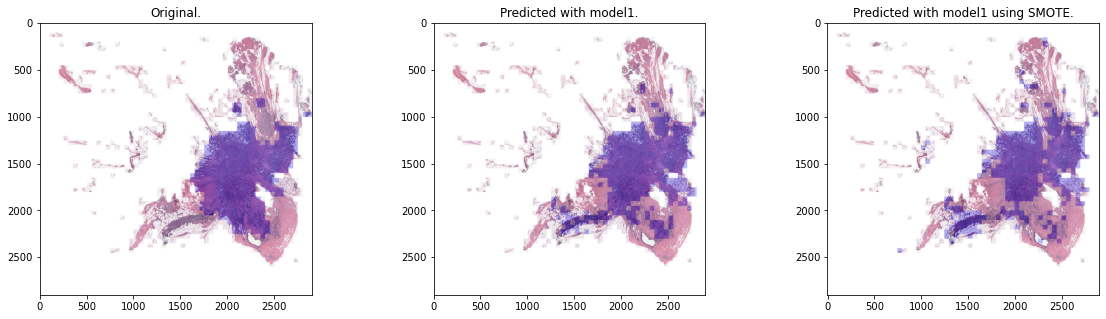

In [212]:
#creating visual preview of original and predicted values highlighted
fig, ax = plt.subplots(1,3,figsize=(20,5))

ax[0].imshow(img)
ax[0].set_title('Original.')

ax[1].imshow(img1)
ax[1].set_title('Predicted with model1.')

ax[2].imshow(img2)
ax[2].set_title('Predicted with model1 using SMOTE.');

plt.show()

In [ ]:
loaded_model2 = load_model('./model2.h5')
loaded_model2.summary()

In [ ]:
y_predicted2 = loaded_model2.predict(X_test_patient)
y_predicted2 = np.argmax(y_predicted2,axis=1)
y_predicted2

In [ ]:
matrix = confusion_matrix(y_test_patient, y_predicted2)
print(matrix)

In [ ]:
test_patient['is_cancer'] = y_predicted2
img3 = visualise_tissue_one_patient(test_patient,highlight=True)

In [ ]:
loaded_model2_smote = load_model('./model2_smote.h5')
loaded_model2_smote.summary()

In [ ]:
y_predicted2_smote = loaded_model2_smote.predict(X_test_patient)
y_predicted2_smote = np.argmax(y_predicted2_smote,axis=1)
y_predicted2_smote

In [ ]:
matrix = confusion_matrix(y_test_patient, y_predicted2_smote)
print(matrix)

In [ ]:
test_patient['is_cancer'] = y_predicted2_smote
img4 = visualise_tissue_one_patient(test_patient,highlight=True)

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(20,5))

ax[0].imshow(img)
ax[0].set_title('Original.')

ax[1].imshow(img3)
ax[1].set_title('Predicted with model2.')

ax[2].imshow(img4)
ax[2].set_title('Predicted with model2 using SMOTE.');

plt.show()